# Data cleaning, Feature engineering and Target variable

In this notebook I consider all datasets provided. I will merge them together in order to create a complete and informative dataset to target the challenge objective.

The challenge set some explicit requirements for this step:

> ### 2. Data Cleaning 
> Select at least two datasets
>  * Detect weird values, outliers and missing values. 
>      * Which techniques or algorithms do you use to detect them?
>      * How do you treat them? Is it ok to remove them from the dataset? 
>      * Is there any evident inconsistency in the data? If yes, how would you clean the data to overcome it? 
>  * Why did you select these datasets?
>  
> ### 3. Target Variable
> As in the real world, you are asked to create the target variable for this challenge by keeping in mind the challenge objective stated above. 
>  * Create a data matrix to feed models (you can decide to use only a subset of the given datasets).
>  * Which granularity did you select and why?
>  * Which columns identify each occurence?
>  * Propose a target variable construction, write it with a mathematics formula and implement it. 
>  * Explain and validate every choice/assumption you made in the previous point, also with business intuitions. 
>  * If you decide to not have a target variable to predict, explain carefully your decision and how this could influence next steps in this analysis.  
> 
> ### 4. Features Engineering
> Given or not the target variable defined above, you can choose the features to use in a predictive model. 
>  * Create new features (we suggest ~3) from existing columns. Explain the intuition behind them.
>  * Select a subset of features to use to train a predictive model. The selection process should be rigorous and reproducible. 

I will answer to these questions in this notebook.

The dataset being considered are the following:
1. ANAGRAFICA_CLIENTI.csv: registry of customers owning NPL;
2. GARANZIE.csv: information related to customers guarantees;
3. CENTRALE_RISCHI.csv: monthly data related to customers total debt exposure w.r.t. other banks;
4. MUTUI.csv: monthly data related to NPL coming from mortgages;
5. CC.csv: monthly data related to NPL coming from bank credit and credit limit;
6. PERIMETRO_INIZIALE.csv: monthly data related to NPL customers

The reason to consider all these datasets is because all of them contain relevant information to use to train predictive models to target the challenge objective. The relevant information extracted from each dataset will be discussed in detail. The only dataset which have not been considered is TRANSCODIFICA_GARANZIE.csv. This dataset contains only label values for one of the categorical column of the dataset GARANZIE.csv which is not found to be usefull for the modelling phase.

Each dataset is processed as follow:
* Open the dataset and check overall consistency;
* Highlight important information to reach the goal of the data challenge;
* Define a strategy to aggregate the data if necessary;

The resulting datasets are then merged together over relevant common keys.

Invalid data rows and NaN values are then adressed on the merged dataset.

The target variables is also defined in this dataset.

The final resulting dataset is exported on a csv file for further analysis.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os.path as path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

DATA_PATH = 'DATA'

## Anagrafica clienti

The dataset could be merged to the 'PERIMETRO_INIZIALE' using the 'CUSTOMER_ID' key.

In [2]:
df_ac = pd.read_csv(path.join(DATA_PATH, 'ANAGRAFICA_CLIENTI.csv'), sep=';', decimal=',', low_memory=False)

In [3]:
df_ac.shape

(42460, 37)

In [4]:
df_ac['ID_CUSTOMER'].unique().shape

(28126,)

### Logic to extract unique information:

The dataset contain 42'460 entries in total. Only 28'126 correspond to unique 'ID_CUSTOMER' (i.e. 2 less than the number of 'ID_CUSTOMER' in 'PERIMETRO_INIZIALE'). This is expected since the dataset contain the registry data of customers and their *connection* related to the NPL. Connection are identified by the same 'CURSTOMER_ID' but a different 'COD_TIPO_COLLEGAMENTO':

* MON (Monointestazioni): Appear only once as MON, could be duplicated as TIT
* GCO (Cointestazioni): One entry for each 'cointestatario', but only one is flagged as 'Principal'
* TIT (Titolare): TIT customer appear at least once as MON

The logic to extract the information of the principal customer is as follow:

* COD_TIPO_COLLEGAMENTO == 'GCO' & FLG_PRIMO_INTESTATARIO == True
* COD_TIPO_COLLEGAMENTO == MON

With this logic I am not considering the 'GCO' not flagged as 'Principal' and the 'TIT' customer. For the former, it is assumed that the most important information is carried by the principal, for the latter the information is carried by the corresponding 'MON' with the same 'CUSTOMER_ID'. 

This logic could be improved later if necessary. 


In [5]:
df_ac=df_ac.loc[(df_ac['COD_TIPO_COLLEGAMENTO'] == 'MON')|((df_ac['COD_TIPO_COLLEGAMENTO'] == 'GCO')&(df_ac['FLG_PRIMO_INTESTATARIO'] == True))]

In [6]:
df_ac['ID_CUSTOMER'].shape

(28126,)

In [7]:
df_ac['ID_CUSTOMER'].unique().shape

(28126,)

### COD_TIPO_NGD:
The data contain different type of customers as indicated by the column COD_TIPO_NDG: 

* Persona Giuridica (Labelled as G);
* Persona Fisica (Labelled as F);
* Cointestazioni (Labelled as C);

The proportions are as follow:

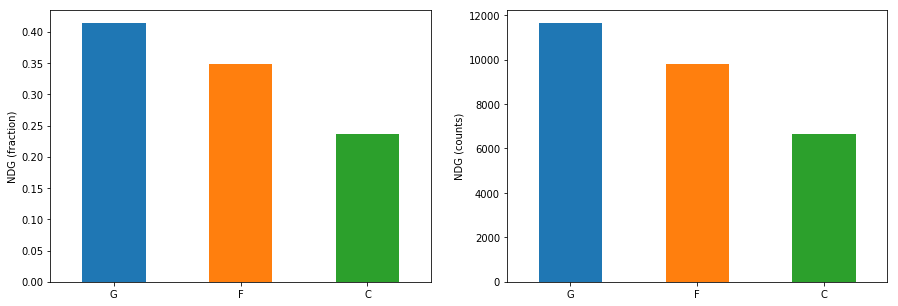

In [8]:
tmp=pd.concat([
    df_ac['COD_TIPO_NDG'].value_counts()
    ,df_ac['COD_TIPO_NDG'].value_counts(normalize=True)
], axis=1, keys=['Counts','Rel'])

_,ax=plt.subplots(1,2, figsize=(15,5))
ax[0] = tmp['Rel'].plot.bar(ax=ax[0], rot=0)
ax[0].set_xlabel('')
ax[0].set_ylabel('NDG (fraction)')

ax[1] = tmp['Counts'].plot.bar(ax=ax[1], rot=0)
ax[1].set_xlabel('')
ax[1].set_ylabel('NDG (counts)')
plt.show()

A sub-classification is given by the column COD_SPECIE_GIURIDICA, mainly for G customers:

In [9]:
df_ac.groupby('COD_TIPO_NDG')['COD_SPECIE_GIURIDICA'].value_counts()

COD_TIPO_NDG  COD_SPECIE_GIURIDICA
C             CO                      6661
F             PF                      9802
              PFE                       12
              PFI                        2
              PFINB                      2
G             SRL                     4247
              DI                      4059
              SNC                     1408
              SAS                     1281
              SCRL                     261
              SPA                      177
              SS                       100
              ENTE                      40
              CONS                      14
              SE                        13
              FALNC                     12
              SDF                        9
              COND                       5
              COOSC                      5
              PSCRL                      4
              ASNR                       3
              SCRLA                      3
              FALLC

### Strategy
* The dataset has been reduced to one row per customers.
* There is no need to prepare aggregates.
* As a first step, the information of the 'COLLEGATO' will not be considered.
* If necessary, it will be considered later on a second iteration.
* The following columns are considered for the models:

In [10]:
cols_to_keep=['ID_CUSTOMER'
         ,'COD_SPECIE_GIURIDICA' # Cat
         ,'NUM_COMPONENTI_COINTESTAZIONE' # Num
         ,'COD_TIPO_NDG' # Cat
         ,'COD_PROVINCIA_RESIDENZA' # Cat
         ,'DES_PROFESSIONE_ATTIVITA' # Cat
         ,'DES_RAE' # Cat
         ,'DES_SAE'# Cat
         ,'TMS_COSTITUZIONE_PG' # Num
         ,'TMS_NASCITA_PF' # Num
         ,'DES_PROVINCIA_NASCITA' # Cat
         ,'TMS_SCHEDATURA' # Cat
         ,'TMS_ESTINZIONE'# Cat
        ]

In [11]:
df_ac=df_ac[cols_to_keep].set_index('ID_CUSTOMER').sort_index()
df_ac.head()

,COD_SPECIE_GIURIDICA,NUM_COMPONENTI_COINTESTAZIONE,COD_TIPO_NDG,COD_PROVINCIA_RESIDENZA,DES_PROFESSIONE_ATTIVITA,DES_RAE,DES_SAE,TMS_COSTITUZIONE_PG,TMS_NASCITA_PF,DES_PROVINCIA_NASCITA,TMS_SCHEDATURA,TMS_ESTINZIONE
ID_CUSTOMER,,,,,,,,,,,,
1,SRL,0.0,G,TA,IMP. CON DIPEND. DA 0 A 19,ARTICOLI ABBIGLIAMENTO E ACCES,IMPRESE PRODUTTIVE,1997.0,NaN,NaN,1999.0,NaN
2,SRL,0.0,G,NaN,IMP. CON DIPEND. DA 0 A 19,SERVIZI RICREATIVI E CULTURALI,IMPRESE PRODUTTIVE,NaN,NaN,NaN,1999.0,NaN
3,PF,0.0,F,NaN,IMPIEGATI,NaN,FAMIGLIE CONSUMATRICI,NaN,1975.0,NaN,2000.0,NaN
4,PF,0.0,F,NaN,IMPIEGATI,NaN,FAMIGLIE CONSUMATRICI,NaN,1966.0,NaN,2000.0,NaN
5,SRL,0.0,G,BA,IMP. CON DIPEND. DA 0 A 19,COMM.INGROS.ALIM.BEVANDE TABAC,IMPRESE PRODUTTIVE,1997.0,NaN,NaN,2000.0,NaN


## Garanzie
The dataset could be merged to the 'PERIMETRO_INIZIALE' using the 'CUSTOMER_ID' key.

In [12]:
df_g = pd.read_csv(path.join(DATA_PATH, 'GARANZIE.csv'), sep=';', decimal=',', low_memory=False)

In [13]:
df_g.shape

(38998, 14)

In [14]:
df_g['ID_CUSTOMER'].unique().shape

(19157,)

In [15]:
df_g['ID_RAPPORTO'].unique().shape

(38998,)

In [16]:
df_g['ID_GARANTE'].unique().shape

(26615,)

In [17]:
df_g.sort_values(by='ID_CUSTOMER').head(10)

,ID_CUSTOMER,ID_RAPPORTO,ID_GARANTE,COD_STATO_KTO,DAT_CHIUSR_KTO,COD_TIP_GAR,DES_TIP_GAR,COD_STATO_GAR,DES_STATO_GAR,COD_SSA_ORIGIN_GAR,COD_FORM_TEC_GAR,DES_FORM_TEC_GAR,DAT_PERFZNMNT_GAR,IMP_GAR
219,1,68751,52016,1,NaN,NaN,NaN,504,Escussa attivata con esito negativo,GK,1010,Fideiussione 1^ ist. omnibus,2005.0,9893.46
675,1,68752,50605,1,NaN,NaN,NaN,504,Escussa attivata con esito negativo,GK,1010,Fideiussione 1^ ist. omnibus,2005.0,9893.46
1580,6,68591,58267,1,NaN,NaN,NaN,301,Perfezionata,GK,1160,Personali altre avallo,2006.0,9893.46
1579,6,68590,58267,1,NaN,NaN,NaN,301,Perfezionata,GK,1010,Fideiussione 1^ ist. omnibus,2006.0,54794.52
408,13,68798,52033,1,NaN,NaN,NaN,301,Perfezionata,GK,1010,Fideiussione 1^ ist. omnibus,2007.0,19025.88
908,14,68095,51028,1,NaN,NaN,NaN,301,Perfezionata,GK,1160,Personali altre avallo,1998.0,1822.64
3308,15,68303,52208,1,NaN,NaN,NaN,301,Perfezionata,GK,1010,Fideiussione 1^ ist. omnibus,1994.0,43234.63
954,20,68226,51560,1,NaN,NaN,NaN,301,Perfezionata,GK,1160,Personali altre avallo,2003.0,2283.11
16,20,68227,106760,1,NaN,S,SPECIFICA,0,PERFEZIONATA,NaN,00100,PRIVILEGIO LEGALE AGRARIO,2002.0,NaN
2188,21,67831,53987,1,NaN,NaN,NaN,301,Perfezionata,GK,1160,Personali altre avallo,2006.0,956.93


* GARANZIE contains data corresponds to 19'157 unique customers, 38'998 unique ID_RAPPORTO and 26'615 unique ID_GARANTE;
* Multiple entry for the same ID_CUSTOMER relate with different ID_RAPPORTO and, sometime, with differen ID_GARANTE. 
* This dataset require to aggregate data in order to provide one row per customer.
* There are categorical features to identify the type and the status of the guarantee.

### Explorative steps:

In [18]:
df_g['COD_STATO_KTO'].value_counts(dropna=False)

1    37760
0     1238
Name: COD_STATO_KTO, dtype: int64

Most of the garanzie are active

In [19]:
df_g['DES_TIP_GAR'].value_counts(dropna=False)

NaN          35664
SPECIFICA     2513
GLOBALE        821
Name: DES_TIP_GAR, dtype: int64

In [20]:
df_g['COD_TIP_GAR'].value_counts(dropna=False)

NaN    35664
S       2513
G        821
Name: COD_TIP_GAR, dtype: int64

In [21]:
df_g['DES_STATO_GAR'].value_counts(dropna=False)

Perfezionata                              21284
Perfezionata Contrattuale                 11788
PERFEZIONATA                               1742
In escussione attivata                     1513
Perfezionata Documentale                   1183
Escussa attivata con esito negativo         732
Estinta trasferita a terzi                  518
In escussione                               129
IN ESCUSSIONE                                41
Receduta                                     22
IN MODIFICA                                  22
Rinuncia perfezionamento                     13
RECEDUTA                                      5
Annullo escussione                            4
Escussa parziamente con esito positivo        2
Name: DES_STATO_GAR, dtype: int64

In [22]:
df_g['COD_STATO_GAR'].value_counts(dropna=False)

301    20777
321    11788
0       1742
502     1513
322     1183
504      732
951      518
305      507
501      129
6         41
401       22
7         22
981       13
5          5
505        4
503        2
Name: COD_STATO_GAR, dtype: int64

* DES_STATO_GAR should be reprocessed because some labels clearly have the same meaning, e.g. Perfezionata and PERFEZIONATA;
* COD_STATO_GAR which enumerate the label in DES_STATO_GAR should also be reprocessed;

In [23]:
df_g['COD_SSA_ORIGIN_GAR'].value_counts(dropna=False)

GK      21724
CMLT    14150
NaN      1810
PGA       632
EPC       517
PEF       141
GIC        24
Name: COD_SSA_ORIGIN_GAR, dtype: int64

In [24]:
# Many items
#df_g['COD_FORM_TEC_GAR'].value_counts(dropna=False)
#df_g['DES_FORM_TEC_GAR'].value_counts(dropna=False)

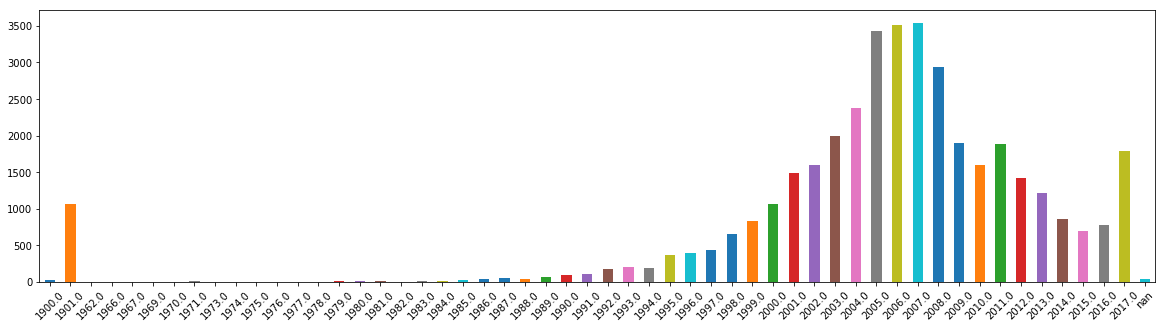

In [25]:
df_g['DAT_PERFZNMNT_GAR'].value_counts(dropna=False).sort_index().plot.bar(rot=45, figsize=(20,5))
plt.show()

In [26]:
df_g.describe()

,ID_CUSTOMER,ID_RAPPORTO,ID_GARANTE,COD_STATO_KTO,DAT_CHIUSR_KTO,COD_STATO_GAR,DAT_PERFZNMNT_GAR,IMP_GAR
count,38998.000000,38998.000000,38998.000000,38998.000000,523.000000,38998.000000,38962.000000,3.718800e+04
mean,15828.424150,87259.500000,45054.939305,0.968255,2016.206501,314.993410,2003.381936,1.227356e+04
std,7417.622478,11257.897236,27209.602867,0.175323,0.414530,111.305353,18.333096,1.190395e+05
min,1.000000,67761.000000,21.000000,0.000000,2015.000000,0.000000,1900.000000,0.000000e+00
25%,9710.000000,77510.250000,21563.250000,1.000000,2016.000000,301.000000,2003.000000,2.923765e+03
50%,15987.000000,87259.500000,50420.500000,1.000000,2016.000000,301.000000,2006.000000,7.838660e+03
75%,22268.750000,97008.750000,56023.750000,1.000000,2016.000000,321.000000,2010.000000,1.484018e+04
max,28128.000000,106758.000000,107943.000000,1.000000,2017.000000,981.000000,2017.000000,1.826484e+07


### Strategy

I expect that the most important information provided by this dataset is the total amount of the guaranty.

As a first step, I aggregate the information for each customer as follow:

* 'ID_CUSTOMER': Keep the value as a key for merging with other dataset
* 'ID_RAPPORTO': Count the number of active RAPPORTO 
* 'ID_GARANTE': Count the number of unique GARANTE
* 'COD_STATO_KTO': True if at least one is active, False otherwise
* 'DAT_CHIUSR_KTO': Latest date
* 'COD_TIP_GAR': Drop
* 'DES_TIP_GAR': Drop
* 'COD_STATO_GAR': Drop
* 'DES_STATO_GAR': Drop
* 'COD_SSA_ORIGIN_GAR': Drop
* 'COD_FORM_TEC_GAR': Drop
* 'DES_FORM_TEC_GAR': Drop
* 'DAT_PERFZNMNT_GAR': Latest date
* 'IMP_GAR': Sum

The reason to drop columns related to the type, status and origin of the guarantee is to maintain the dataset as simple as possibile. As a first approach, I prefer to drop these columns.

In [27]:
df_g=df_g.groupby(['ID_CUSTOMER']).agg({
    'ID_RAPPORTO': pd.Series.nunique
    ,'ID_GARANTE': pd.Series.nunique
    ,'COD_STATO_KTO': pd.Series.any
    ,'DAT_CHIUSR_KTO': pd.Series.max
    ,'DAT_PERFZNMNT_GAR': pd.Series.max
    ,'IMP_GAR' : pd.Series.sum
})

df_g.rename(columns={
    'ID_RAPPORTO': 'NUM_ID_RAPPORTO'
    ,'ID_GARANTE': 'NUM_ID_GARANTE'
}, inplace=True)

In [28]:
df_g.head()

,NUM_ID_RAPPORTO,NUM_ID_GARANTE,COD_STATO_KTO,DAT_CHIUSR_KTO,DAT_PERFZNMNT_GAR,IMP_GAR
ID_CUSTOMER,,,,,,
1,2,2,True,NaN,2005.0,19786.92
6,2,1,True,NaN,2006.0,64687.98
13,1,1,True,NaN,2007.0,19025.88
14,1,1,True,NaN,1998.0,1822.64
15,1,1,True,NaN,1994.0,43234.63


## Centrale Rischi
The dataset provide monthly information and could be merged to the 'PERIMETRO_INIZIALE' using the 'CUSTOMER_ID' and 'NUM_AA_MM' keys.

In [29]:
df_cr = pd.read_csv(path.join(DATA_PATH, 'CENTRALE_RISCHI.csv'), sep=';', decimal=',', low_memory=False)

In [30]:
df_cr.shape

(2829619, 19)

In [31]:
df_cr['ID_CUSTOMER'].unique().shape

(25412,)

In [32]:
df_cr['ID_COLLEGATO'].unique().shape

(3808,)

In [33]:
df_cr['NUM_AA_MM'].unique().shape, df_cr['NUM_AA_MM'].unique().min(), df_cr['NUM_AA_MM'].unique().max()

((33,), 201501, 201709)

* CENTRALE_RISCHI contains montly information covering the reference period from 01-2015 to 09-2017, for a total of 33 months;
* Data corresponds to 25'412 unique customers;
* There are categorical features to identify the type, the status and the volume of the signal provided from other banks 

In [34]:
df_cr.sort_values(by='ID_CUSTOMER').head()

,ID_CUSTOMER,ID_COLLEGATO,COD_SPECIE_SE_DITTA,COD_TIPO_COLLEGAMENTO,COD_SPECIE_GIURIDICA_TIT,COD_FENMN,DES_FENMN,COD_LIV_INTRMDR,DES_LIV_INTRMDR,NUM_AA_MM,COD_STATO_RAPPRT,DES_STATO_RAPPRT,IMP_ACCRDT,IMP_UTLZT,IMP_VAL_GAR,IMP_GARNTT,IMP_SCONFNM,IMP_MARGN_UTLZ,NUM_ENTI_SEGNALANTI
191,1,NaN,NaN,NaN,NaN,551000,SOFFERENZE,1,LIVELLO BANCA,201601,902,RAPPORTI NON CONTESTATI RAPPORTI NON CONTESTATI,0.0,3387.90,0.0,0.0,0.0,0.0,4.0
137,1,NaN,NaN,NaN,NaN,551000,SOFFERENZE,1,LIVELLO BANCA,201502,902,RAPPORTI NON CONTESTATI RAPPORTI NON CONTESTATI,0.0,3387.90,0.0,0.0,0.0,0.0,4.0
138,1,NaN,NaN,NaN,NaN,551000,SOFFERENZE,2,LIVELLO GRUPPO CREDITIZIO,201502,902,RAPPORTI NON CONTESTATI RAPPORTI NON CONTESTATI,0.0,4725.04,0.0,0.0,0.0,0.0,4.0
139,1,NaN,NaN,NaN,NaN,551000,SOFFERENZE,5,LIVELLO SISTEMA CREDITIZIO,201502,902,RAPPORTI NON CONTESTATI RAPPORTI NON CONTESTATI,0.0,9720.32,0.0,0.0,0.0,0.0,4.0
140,1,NaN,NaN,NaN,NaN,555200,CREDITI A PERDITE,2,LIVELLO GRUPPO CREDITIZIO,201502,0,VALORE NON PREVISTO PER IL CODICE STATO RAPPORTO,0.0,0.00,0.0,0.0,0.0,0.0,4.0


In [35]:
df_cr.describe()

,ID_CUSTOMER,ID_COLLEGATO,COD_FENMN,COD_LIV_INTRMDR,NUM_AA_MM,COD_STATO_RAPPRT,IMP_ACCRDT,IMP_UTLZT,IMP_VAL_GAR,IMP_GARNTT,IMP_SCONFNM,IMP_MARGN_UTLZ,NUM_ENTI_SEGNALANTI
count,2.829619e+06,457597.000000,2.829619e+06,2.829619e+06,2.829619e+06,2.829619e+06,2.829619e+06,2.829619e+06,2.829619e+06,2.829619e+06,2.829619e+06,2.829619e+06,2.749693e+06
mean,1.477725e+04,34973.006945,5.514703e+05,3.033021e+00,2.015905e+05,6.661832e+02,1.777137e+03,8.193439e+03,2.088904e+03,4.558886e+03,5.648975e+02,1.731713e+02,2.590740e+00
std,7.867559e+03,9902.771270,1.430683e+03,1.785818e+00,7.820060e+01,3.585032e+02,1.299303e+04,5.308989e+04,3.025214e+04,2.387785e+04,7.205106e+03,3.656546e+03,2.159907e+00
min,1.000000e+00,19.000000,5.502000e+05,1.000000e+00,2.015010e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,8.308000e+03,30309.000000,5.510000e+05,1.000000e+00,2.015080e+05,1.790000e+02,0.000000e+00,4.349300e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
50%,1.492500e+04,35947.000000,5.510000e+05,2.000000e+00,2.016040e+05,9.020000e+02,0.000000e+00,3.692310e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
75%,2.160600e+04,42741.000000,5.510000e+05,5.000000e+00,2.016120e+05,9.020000e+02,0.000000e+00,8.991860e+03,0.000000e+00,5.429680e+03,0.000000e+00,0.000000e+00,3.000000e+00
max,2.812800e+04,47561.000000,5.554000e+05,5.000000e+00,2.017090e+05,9.020000e+02,2.583779e+06,9.761485e+06,4.198527e+06,2.527646e+06,1.420490e+06,9.331706e+05,3.200000e+01


### Check for outliers
The quantiles for some features are set to zero:

* 'IMP_ACCRDT', 
* 'IMP_VAL_GAR', 
* 'IMP_GARNTT', 
* 'IMP_SCONFNM', 
* 'IMP_MARGN_UTLZ'

This might be due to some outliers that push the distribution of these features to the left.

Let's have a look at these features with some histograms:

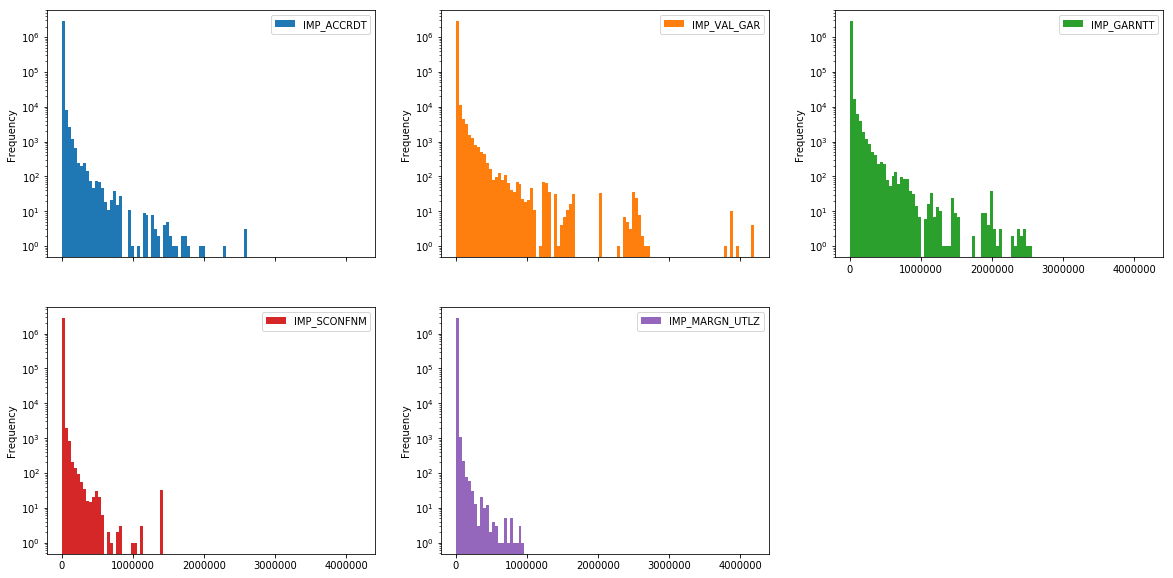

In [36]:
cols=['IMP_ACCRDT', 'IMP_VAL_GAR', 'IMP_GARNTT', 'IMP_SCONFNM', 'IMP_MARGN_UTLZ']
df_cr[cols].plot.hist(bins=100, logy=True, subplots=True, layout=(2,3), figsize=(20,10))
plt.show()

These numerical features show a positive defined distribution with tails that go quickly to zero (similar to an exponential-like distribution). Intuitively, it means that there are many clients which are granted a small amount and very few clients which are granted a big amount, this make sense. 

What we observe in some of the histograms are tails that extend very far from the distribution. The events in those tails look like outliers and should be studied separately to understand if they are real or not.

The distribution of the z-score shown below provide similar insights. In case these events are not real, i.e. originate from some mistake in the dataset, they could be removed by an arbitrary cut on the z-score.

Since these outliers represent few tenth of events over many thousand, I prefer not to reject them based on an arbitrary argument such as the z-score. It would be better to understand their origin first. Furthermore, I do not expect those few events to have a big impact for the rest of the analysis.

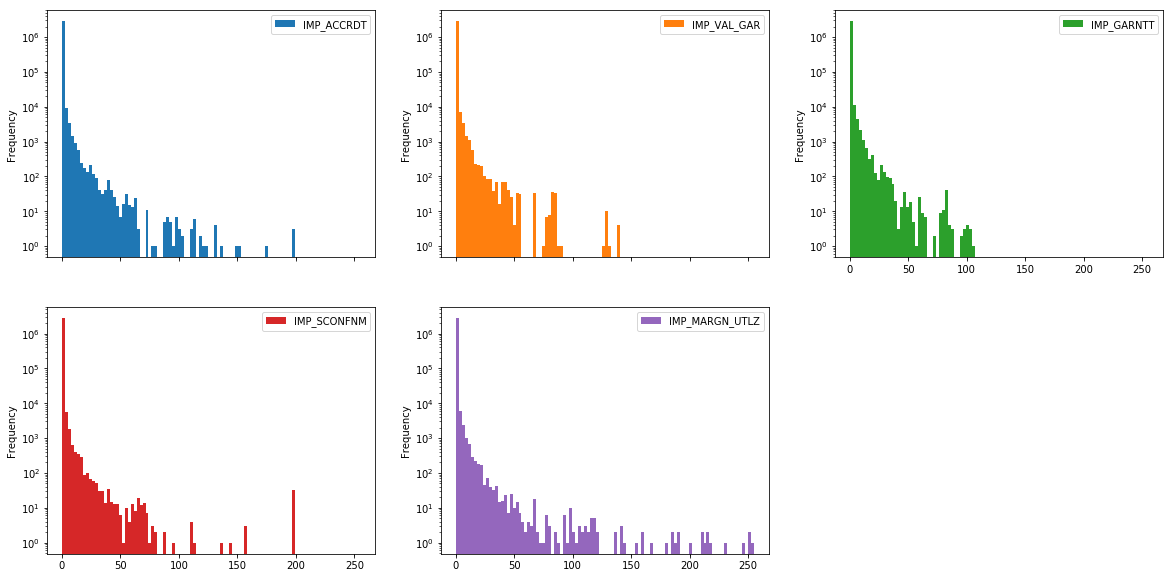

In [37]:
cols=['IMP_ACCRDT', 'IMP_VAL_GAR', 'IMP_GARNTT', 'IMP_SCONFNM', 'IMP_MARGN_UTLZ']

from scipy import stats
zs=df_cr[cols].apply(lambda x: np.abs(stats.zscore(x)), axis=0)
zs.plot.hist(bins=100, logy=True, subplots=True, layout=(2,3), figsize=(20,10))
plt.show()

### Strategy

I expect the most important information contained in this dataset are the different amounts reported and the number of signal received by other banks:

* IMP_ACCRDT
* IMP_UTLZT
* IMP_VAL_GAR
* IMP_GARNTT
* IMP_SCONFNM
* IMP_MARGN_UTLZ
* NUM_ENTI_SEGNALANTI

I aggregate the information by customer and months, summing over the different amounts. For the number of signal received, I consider the max value. 

I neglect the categorical features for simplicity. Since I am aggregating information, categorical would require a particular care.

In [38]:
# Convert dates
df_cr['NUM_AA_MM'] = pd.to_datetime(df_cr['NUM_AA_MM'], format='%Y%m')

In [39]:
df_cr=df_cr.groupby(['ID_CUSTOMER','NUM_AA_MM']).agg({
    'IMP_ACCRDT' : 'sum'
    ,'IMP_UTLZT' : 'sum'
    ,'IMP_VAL_GAR' : 'sum'
    ,'IMP_GARNTT' : 'sum'
    ,'IMP_SCONFNM' : 'sum'
    ,'IMP_MARGN_UTLZ' : 'sum'
    ,'NUM_ENTI_SEGNALANTI' : 'max'
})

In [40]:
df_cr.head()

IMP_ACCRDT  IMP_UTLZT  IMP_VAL_GAR  IMP_GARNTT  \
ID_CUSTOMER NUM_AA_MM                                                    
1           2015-01-01         0.0   17338.05          0.0         0.0   
            2015-02-01         0.0   17833.26          0.0         0.0   
            2015-03-01         0.0   17833.26          0.0         0.0   
            2015-04-01         0.0   17774.81          0.0         0.0   
            2015-05-01         0.0   17774.81          0.0         0.0   

                        IMP_SCONFNM  IMP_MARGN_UTLZ  NUM_ENTI_SEGNALANTI  
ID_CUSTOMER NUM_AA_MM                                                     
1           2015-01-01          0.0             0.0                  4.0  
            2015-02-01          0.0             0.0                  4.0  
            2015-03-01          0.0             0.0                  4.0  
            2015-04-01          0.0             0.0                  4.0  
            2015-05-01          0.0             0.0                  4.0

## CC
The dataset provide monthly information and could be merged to the 'PERIMETRO_INIZIALE' using the 'CUSTOMER_ID' and 'NUM_AA_MM' keys.

In [41]:
df_cc=pd.read_csv(path.join(DATA_PATH, 'CC.csv'), sep=';', decimal=',', low_memory=False)

In [42]:
df_cc.columns

Index(['ID_CUSTOMER', 'ID_RAPPORTO', 'TIPO_KTO', 'TIPO_DEBITO', 'COD_DIVISA',
       'COD_TIP_SALD', 'DES_TIP_SALD', 'DAT_RIF_SALD', 'NUM_AA_MM',
       'IMP_SALD'],
      dtype='object')

In [43]:
df_cc.shape

(2233862, 10)

In [44]:
df_cc['ID_CUSTOMER'].unique().shape

(21629,)

In [45]:
df_cc['ID_RAPPORTO'].unique().shape

(43348,)

In [46]:
df_cc['NUM_AA_MM'].unique().shape, df_cc['NUM_AA_MM'].unique().min(), df_cc['NUM_AA_MM'].unique().max()

((33,), 201501, 201709)

In [47]:
df_cc.head()

,ID_CUSTOMER,ID_RAPPORTO,TIPO_KTO,TIPO_DEBITO,COD_DIVISA,COD_TIP_SALD,DES_TIP_SALD,DAT_RIF_SALD,NUM_AA_MM,IMP_SALD
0,172,110458,9501,BT,EUR,3,Contabile linea capitale,2015,201501,-5632.53
1,172,110458,9501,BT,EUR,3,Contabile linea capitale,2015,201502,-5632.53
2,172,110458,9501,BT,EUR,3,Contabile linea capitale,2015,201503,-5632.53
3,172,110458,9501,BT,EUR,3,Contabile linea capitale,2015,201504,-5632.53
4,172,110458,9501,BT,EUR,3,Contabile linea capitale,2015,201505,-5632.53


* CC contains montly information covering the reference period from 01-2015 to 09-2017, for a total of 33 months;
* Data corresponds to 21'629 unique customers and 43'348 *rapporti*;
* One ID_CUSTOMER is associated with multiple ID_RAPPORTO;
* There are categorical features to identify the type of debt and numerica features to identify the volume of the debt;

### Strategy
CC are grouped per CUSTOMER and per months. The column IMP_SALD is summed over ID_RAPPORTO and pivoted to provide one column for each of its values:
1. 'Contabile linea capitale',
2. 'Contabile linea interessi di mora'
3. 'Credito vantato'

The categorical features indicating the type of debt and the type of account are neglected. Since I am aggregating information, categorical would require a particular care.

In [48]:
# Convert dates
df_cc['NUM_AA_MM'] = pd.to_datetime(df_cc['NUM_AA_MM'], format='%Y%m')

In [49]:
df_cc=df_cc.groupby(['ID_CUSTOMER','NUM_AA_MM','DES_TIP_SALD'])['IMP_SALD'].sum().unstack(-1).fillna(0)

In [50]:
df_cc.head()

DES_TIP_SALD            Contabile linea capitale  \
ID_CUSTOMER NUM_AA_MM                              
1           2015-01-01                  -3222.82   
            2015-02-01                  -3387.86   
            2015-03-01                  -3387.86   
            2015-04-01                  -3387.86   
            2015-05-01                  -3387.86   

DES_TIP_SALD            Contabile linea interessi di mora  Credito vantato  
ID_CUSTOMER NUM_AA_MM                                                       
1           2015-01-01                                0.0         -3222.82  
            2015-02-01                                0.0         -3387.86  
            2015-03-01                                0.0         -3387.86  
            2015-04-01                                0.0         -3387.86  
            2015-05-01                                0.0         -3387.86

## MUTUI
The dataset provide monthly information and could be merged to the 'PERIMETRO_INIZIALE' using the 'CUSTOMER_ID' and 'NUM_AA_MM' keys.

In [51]:
df_m=pd.read_csv(path.join(DATA_PATH, 'MUTUI.csv'), sep=';', decimal=',', low_memory=False)

In [52]:
df_m.columns

Index(['ID_CUSTOMER', 'ID_RAPPORTO', 'TIPO_KTO', 'NUM_AA_MM', 'COD_STATO_KTO',
       'IMP_CAPTL_RESID', 'IMP_TOT_SCADUTO', 'IMP_TOT_MORA', 'IMP_GBV',
       'NUM_RATE_PAGT', 'NUM_RATE_IMPGT', 'TMS_SCADNZ_ULT_RATA_SCADT',
       'IMP_ULTM_RATA_SCADT'],
      dtype='object')

In [53]:
df_m.shape

(3743, 13)

In [54]:
df_m['ID_CUSTOMER'].unique().shape

(523,)

In [55]:
df_m['ID_RAPPORTO'].unique().shape

(548,)

In [56]:
df_m['NUM_AA_MM'].unique().shape, df_m['NUM_AA_MM'].unique().min(), df_m['NUM_AA_MM'].unique().max()

((12,), 201610, 201709)

In [57]:
df_m.head()

,ID_CUSTOMER,ID_RAPPORTO,TIPO_KTO,NUM_AA_MM,COD_STATO_KTO,IMP_CAPTL_RESID,IMP_TOT_SCADUTO,IMP_TOT_MORA,IMP_GBV,NUM_RATE_PAGT,NUM_RATE_IMPGT,TMS_SCADNZ_ULT_RATA_SCADT,IMP_ULTM_RATA_SCADT
0,24726,151325,4000,201610,0,0.0,6627.45,129.84,6757.29,0,1,2015.0,3805.18
1,24726,151325,4000,201611,0,0.0,6627.45,142.02,6769.47,0,1,2015.0,3805.18
2,24726,151325,4000,201612,0,0.0,6627.45,154.20,6781.64,0,1,2015.0,3805.18
3,24726,151325,4000,201701,0,0.0,3805.18,1.62,3806.80,0,0,2015.0,3805.18
4,24726,151326,4000,201610,0,0.0,7610.35,186.66,7797.01,0,1,2015.0,3805.18


In [58]:
df_m.describe()

,ID_CUSTOMER,ID_RAPPORTO,TIPO_KTO,NUM_AA_MM,COD_STATO_KTO,IMP_CAPTL_RESID,IMP_TOT_SCADUTO,IMP_TOT_MORA,IMP_GBV,NUM_RATE_PAGT,NUM_RATE_IMPGT,TMS_SCADNZ_ULT_RATA_SCADT,IMP_ULTM_RATA_SCADT
count,3743.000000,3743.000000,3743.000000,3743.000000,3743.000000,3743.000000,3743.000000,3743.000000,3743.000000,3743.000000,3743.000000,3737.000000,3743.000000
mean,18863.275448,151567.865349,5940.689287,201664.891264,0.051296,515.232308,1669.533086,835.824769,3020.590160,62.810313,28.469410,2013.487824,164.202060
std,7935.960860,164.277963,339.314641,45.596858,0.220630,1307.785925,2481.709419,1409.294411,3975.987769,73.636244,40.817862,4.075758,713.138758
min,38.000000,151292.000000,4000.000000,201610.000000,0.000000,0.000000,0.000000,0.000000,0.880000,0.000000,0.000000,2001.000000,0.000000
25%,12526.000000,151417.000000,6000.000000,201611.000000,0.000000,0.000000,40.370000,1.030000,333.125000,12.000000,4.000000,2010.000000,4.020000
50%,19646.000000,151576.000000,6000.000000,201701.000000,0.000000,0.000000,317.470000,89.210000,831.430000,39.000000,14.000000,2016.000000,21.380000
75%,26504.000000,151712.500000,6000.000000,201704.000000,0.000000,460.640000,2544.880000,1189.140000,4508.790000,88.000000,29.000000,2017.000000,61.760000
max,28127.000000,151839.000000,6000.000000,201709.000000,1.000000,12220.960000,15220.700000,6758.630000,15851.930000,360.000000,213.000000,2017.000000,7610.350000


* MUTUI contains montly information covering the reference period from 10-2016 to 09-2017, for a total of 12 months;
* Data corresponds to 523 unique customers and 548 *rapporti*;
* One ID_CUSTOMER is associated with multiple ID_RAPPORTO;
* There are categorical features to identify the status of the debt and numerical features to identify the volume of the debt, the interests and the number of paied/unpaied instalements;

### Strategy
MUTUI are grouped per CUSTOMER and per months, and aggregated over ID_RAPPORTO as follow:

* 'IMP_CAPTL_RESID': sum
* 'IMP_TOT_SCADUTO': sum
* 'IMP_TOT_MORA': sum
* 'IMP_GBV': sum
* 'NUM_RATE_PAGT': sum
* 'NUM_RATE_IMPGT': sum 
* 'TMS_SCADNZ_ULT_RATA_SCADT': max
* 'IMP_ULTM_RATA_SCADT': sum

The categorical features indicating the type of debt and the type of rapporto are neglected. Since I am aggregating information, categorical would require a particular care.

In [59]:
# Convert dates
df_m['NUM_AA_MM'] = pd.to_datetime(df_m['NUM_AA_MM'], format='%Y%m')

In [60]:
df_m=df_m.groupby(['ID_CUSTOMER','NUM_AA_MM']).agg({
    'IMP_CAPTL_RESID': 'sum'
    ,'IMP_TOT_SCADUTO': 'sum'
    ,'IMP_TOT_MORA': 'sum'
    ,'IMP_GBV': 'sum'
    ,'NUM_RATE_PAGT': 'sum'
    ,'NUM_RATE_IMPGT': 'sum'
    ,'TMS_SCADNZ_ULT_RATA_SCADT': 'max'
    ,'IMP_ULTM_RATA_SCADT': 'sum'

})

In [61]:
# Rename in otder to avoid conflict when merging with PERIMETRO_INIZIALE
df_m.rename(columns={'IMP_GBV':'IMP_GBV_MUTUI'}, inplace=True)

In [62]:
df_m.head()

IMP_CAPTL_RESID  IMP_TOT_SCADUTO  IMP_TOT_MORA  \
ID_CUSTOMER NUM_AA_MM                                                    
38          2016-10-01              0.0           322.13        458.88   
            2016-11-01              0.0           322.13        459.75   
            2016-12-01              0.0           322.13        460.62   
            2017-01-01              0.0           322.13        461.54   
            2017-02-01              0.0           322.13        462.35   

                        IMP_GBV_MUTUI  NUM_RATE_PAGT  NUM_RATE_IMPGT  \
ID_CUSTOMER NUM_AA_MM                                                  
38          2016-10-01         781.01             21               3   
            2016-11-01         781.87             21               3   
            2016-12-01         782.74             21               3   
            2017-01-01         783.67             21               3   
            2017-02-01         784.47             21               3   

                        TMS_SCADNZ_ULT_RATA_SCADT  IMP_ULTM_RATA_SCADT  
ID_CUSTOMER NUM_AA_MM                                                   
38          2016-10-01                     2002.0               141.22  
            2016-11-01                     2002.0               141.22  
            2016-12-01                     2002.0               141.22  
            2017-01-01                     2002.0               141.22  
            2017-02-01                     2002.0               141.22

## Perimetro Iniziale
Consider the version of this file preprocessed in the notebook *exploration_1.ipynb*

The keys features to merge with the other datasets are 'ID_CUSTOMER' and 'NUM_YYYYMM'

In [63]:
df_pi=pd.read_csv(path.join(DATA_PATH, 'PERIMETRO_INIZIALE_PREPROCESS.csv'), parse_dates=['NUM_ANNO', 'NUM_YYYYMM', 'NUM_DATA_SOFFERENZA'])

In [64]:
df_pi.sort_values(by=['ID_CUSTOMER','NUM_YYYYMM'], inplace=True)

In [65]:
# Remove IMP_INCASSI_TOT which knows the future....
df_pi.drop(columns=['IMP_INCASSI_TOT'], inplace=True)

In [66]:
df_pi.shape

(525924, 11)

In [67]:
df_pi.head()

,NUM_ANNO,NUM_YYYYMM,FILIALE,ID_CUSTOMER,NUM_DATA_SOFFERENZA,IMP_GBV,IMP_INCASSI,IMP_CUSUM_INCASSI,MAX_IMP_GBV,RECOVERY_RATE_TOTAL,NUM_MONTHS_SOFFERENZA
23,2015-01-01,2015-01-01,13484,1,2009-01-01,3222.83,0.0,0.0,3561.0,0.0,71
24,2015-01-01,2015-02-01,13484,1,2009-01-01,3387.87,0.0,0.0,3561.0,0.0,73
25,2015-01-01,2015-03-01,13484,1,2009-01-01,3387.87,0.0,0.0,3561.0,0.0,73
26,2015-01-01,2015-04-01,13484,1,2009-01-01,3387.87,0.0,0.0,3561.0,0.0,74
27,2015-01-01,2015-05-01,13484,1,2009-01-01,3387.87,0.0,0.0,3561.0,0.0,75


## Merge all datasets

The following dataset will be merged with a left join:
* df_pi: Perimetro iniziale, ID_CUSTOMER, NUM_YYYYMM
* df_ac: Anagrafica Clienti, ID_CUSTOMER
* df_g: Garanzie, ID_CUSTOMER
* df_cr: Centrale Rischi, ID_CUSTOMER, NUM_AA_MM
* df_cc: Conti Correnti, ID_CUSTOMER, NUM_AA_MM
* df_m: Mutui, ID_CUSTOMER, NUM_AA_MM

The left join is required because the baseline information we want to enrich is contained in PERIMETRO_INIZIALE which will be the first dataset (i.e. the one on the left during the merges). We are not interested in information on customers or date not contained in PERIMETRO_INIZIALE.

In [68]:
df_pi.shape

(525924, 11)

In [69]:
df_cr.shape

(679988, 7)

In [70]:
df_cc.shape

(468386, 3)

In [71]:
df_m.shape

(3555, 8)

In [72]:
df=df_pi.merge(df_cc, how='left', left_on=['ID_CUSTOMER','NUM_YYYYMM'], right_index=True)
print(df.shape)
df=df.merge(df_cr, how='left', left_on=['ID_CUSTOMER','NUM_YYYYMM'], right_index=True)
print(df.shape)
df=df.merge(df_m, how='left', left_on=['ID_CUSTOMER','NUM_YYYYMM'], right_index=True)
print(df.shape)
df=df.merge(df_ac, how='left', left_on=['ID_CUSTOMER'], right_index=True)
print(df.shape)
df=df.merge(df_g, how='left', left_on=['ID_CUSTOMER'], right_index=True)

(525924, 14)
(525924, 21)
(525924, 29)
(525924, 41)


In [73]:
with pd.option_context('display.max_columns', None):
    display(df)

,NUM_ANNO,NUM_YYYYMM,FILIALE,ID_CUSTOMER,NUM_DATA_SOFFERENZA,IMP_GBV,IMP_INCASSI,IMP_CUSUM_INCASSI,MAX_IMP_GBV,RECOVERY_RATE_TOTAL,NUM_MONTHS_SOFFERENZA,Contabile linea capitale,Contabile linea interessi di mora,Credito vantato,IMP_ACCRDT,IMP_UTLZT,IMP_VAL_GAR,IMP_GARNTT,IMP_SCONFNM,IMP_MARGN_UTLZ,NUM_ENTI_SEGNALANTI,IMP_CAPTL_RESID,IMP_TOT_SCADUTO,IMP_TOT_MORA,IMP_GBV_MUTUI,NUM_RATE_PAGT,NUM_RATE_IMPGT,TMS_SCADNZ_ULT_RATA_SCADT,IMP_ULTM_RATA_SCADT,COD_SPECIE_GIURIDICA,NUM_COMPONENTI_COINTESTAZIONE,COD_TIPO_NDG,COD_PROVINCIA_RESIDENZA,DES_PROFESSIONE_ATTIVITA,DES_RAE,DES_SAE,TMS_COSTITUZIONE_PG,TMS_NASCITA_PF,DES_PROVINCIA_NASCITA,TMS_SCHEDATURA,TMS_ESTINZIONE,NUM_ID_RAPPORTO,NUM_ID_GARANTE,COD_STATO_KTO,DAT_CHIUSR_KTO,DAT_PERFZNMNT_GAR,IMP_GAR
23,2015-01-01,2015-01-01,13484,1,2009-01-01,3222.83,0.00,0.00,3561.00,0.000000,71,-3222.82,0.0,-3222.82,0.00,17338.05,0.00,0.00,0.00,0.00,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SRL,0.0,G,TA,IMP. CON DIPEND. DA 0 A 19,ARTICOLI ABBIGLIAMENTO E ACCES,IMPRESE PRODUTTIVE,1997.0,NaN,NaN,1999.0,NaN,2.0,2.0,True,NaN,2005.0,19786.92
24,2015-01-01,2015-02-01,13484,1,2009-01-01,3387.87,0.00,0.00,3561.00,0.000000,73,-3387.86,0.0,-3387.86,0.00,17833.26,0.00,0.00,0.00,0.00,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SRL,0.0,G,TA,IMP. CON DIPEND. DA 0 A 19,ARTICOLI ABBIGLIAMENTO E ACCES,IMPRESE PRODUTTIVE,1997.0,NaN,NaN,1999.0,NaN,2.0,2.0,True,NaN,2005.0,19786.92
25,2015-01-01,2015-03-01,13484,1,2009-01-01,3387.87,0.00,0.00,3561.00,0.000000,73,-3387.86,0.0,-3387.86,0.00,17833.26,0.00,0.00,0.00,0.00,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SRL,0.0,G,TA,IMP. CON DIPEND. DA 0 A 19,ARTICOLI ABBIGLIAMENTO E ACCES,IMPRESE PRODUTTIVE,1997.0,NaN,NaN,1999.0,NaN,2.0,2.0,True,NaN,2005.0,19786.92
26,2015-01-01,2015-04-01,13484,1,2009-01-01,3387.87,0.00,0.00,3561.00,0.000000,74,-3387.86,0.0,-3387.86,0.00,17774.81,0.00,0.00,0.00,0.00,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SRL,0.0,G,TA,IMP. CON DIPEND. DA 0 A 19,ARTICOLI ABBIGLIAMENTO E ACCES,IMPRESE PRODUTTIVE,1997.0,NaN,NaN,1999.0,NaN,2.0,2.0,True,NaN,2005.0,19786.92
27,2015-01-01,2015-05-01,13484,1,2009-01-01,3387.87,0.00,0.00,3561.00,0.000000,75,-3387.86,0.0,-3387.86,0.00,17774.81,0.00,0.00,0.00,0.00,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SRL,0.0,G,TA,IMP. CON DIPEND. DA 0 A 19,ARTICOLI ABBIGLIAMENTO E ACCES,IMPRESE PRODUTTIVE,1997.0,NaN,NaN,1999.0,NaN,2.0,2.0,True,NaN,2005.0,19786.92
28,2015-01-01,2015-06-01,13484,1,2009-01-01,3387.87,0.00,0.00,3561.00,0.000000,76,-3387.86,0.0,-3387.86,0.00,17774.81,0.00,0.00,0.00,0.00,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SRL,0.0,G,TA,IMP. CON DIPEND. DA 0 A 19,ARTICOLI ABBIGLIAMENTO E ACCES,IMPRESE PRODUTTIVE,1997.0,NaN,NaN,1999.0,NaN,2.0,2.0,True,NaN,2005.0,19786.92
29,2015-01-01,2015-07-01,13484,1,2009-01-01,3387.87,0.00,0.00,3561.00,0.000000,77,-3387.86,0.0,-3387.86,0.00,17803.19,0.00,0.00,0.00,0.00,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SRL,0.0,G,TA,IMP. CON DIPEND. DA 0 A 19,ARTICOLI ABBIGLIAMENTO E ACCES,IMPRESE PRODUTTIVE,1997.0,NaN,NaN,1999.0,NaN,2.0,2.0,True,NaN,2005.0,19786.92
30,2015-01-01,2015-08-01,13484,1,2009-01-01,3387.87,0.00,0.00,3561.00,0.000000,78,-3387.86,0.0,-3387.86,0.00,17803.19,0.00,0.00,0.00,0.00,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SRL,0.0,G,TA,IMP. CON DIPEND. DA 0 A 19,ARTICOLI ABBIGLIAMENTO E ACCES,IMPRESE PRODUTTIVE,1997.0,NaN,NaN,1999.0,NaN,2.0,2.0,True,NaN,2005.0,19786.92
31,2015-01-01,2015-09-01,13484,1,2009-01-01,3387.87,0.00,0.00,3561.00,0.000000,79,-3387.86,0.0,-3387.86,0.00,17803.19,0.00,0.00,0.00,0.00,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SRL,0.0,G,TA,IMP. CON DIPEND. DA 0 A 19,ARTICOLI ABBIGLIAMENTO E ACCES,IMPRESE PRODUTTIVE,1997.0,NaN,NaN,1999.0,NaN,2.0,2.0,True,NaN,2005.0,19786.92
32,2015-01-01,2015-10-01,13484,1,2009-01-01,3387.87,0.00,0.00,3561.00,0.000000,80,-3387.86,0.0,-3387.86,0.00,15497.57,0.00,0.00,0.00,0.00,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SRL,0.0,G,TA,IMP. CON DIPEND. DA 0 A 19,ARTICOLI ABBIGLIAMENTO E ACCES,IMPRESE PRODUTTIVE,1997.0,NaN,NaN,1999.0,NaN,2.0,2.0,True,NaN,2005.0,19786.92


### Let's deal with NAN

In [74]:
df.isnull().sum(axis = 0)

NUM_ANNO                                  0
NUM_YYYYMM                                0
FILIALE                                   0
ID_CUSTOMER                               0
NUM_DATA_SOFFERENZA                       0
IMP_GBV                                   0
IMP_INCASSI                               0
IMP_CUSUM_INCASSI                         0
MAX_IMP_GBV                               0
RECOVERY_RATE_TOTAL                       0
NUM_MONTHS_SOFFERENZA                     0
Contabile linea capitale             141706
Contabile linea interessi di mora    141706
Credito vantato                      141706
IMP_ACCRDT                            72759
IMP_UTLZT                             72759
IMP_VAL_GAR                           72759
IMP_GARNTT                            72759
IMP_SCONFNM                           72759
IMP_MARGN_UTLZ                        72759
NUM_ENTI_SEGNALANTI                   80111
IMP_CAPTL_RESID                      523635
IMP_TOT_SCADUTO                 

* Nan on numerical features can simply be replaced by 0 since a missing value means the value is actually 0;
* Nan on categorical features are not of any concern since the categoricals will be one-hot encoded later;
* Nan on dates cannot not be set to zero or other pre-defined values since the feature will not make sense as date. At this first stage I prefer to drop features representing dates.

In [75]:
cols=['IMP_ACCRDT', 'IMP_UTLZT', 'IMP_VAL_GAR', 'IMP_GARNTT', 'IMP_SCONFNM',
      'IMP_MARGN_UTLZ', 'NUM_ENTI_SEGNALANTI', 'Contabile linea capitale',
      'Contabile linea interessi di mora', 'Credito vantato','IMP_CAPTL_RESID', 
      'IMP_TOT_SCADUTO', 'IMP_TOT_MORA', 'IMP_GBV_MUTUI','NUM_RATE_PAGT', 'NUM_RATE_IMPGT',
      'IMP_ULTM_RATA_SCADT', 'NUM_COMPONENTI_COINTESTAZIONE','IMP_GAR', 'NUM_ID_RAPPORTO', 
      'NUM_ID_GARANTE','COD_STATO_KTO']

df[cols]=df.loc[:, cols].fillna(0)

In [76]:
cols=['TMS_SCADNZ_ULT_RATA_SCADT','TMS_COSTITUZIONE_PG','TMS_NASCITA_PF',
      'TMS_SCHEDATURA','TMS_ESTINZIONE','DAT_CHIUSR_KTO','DAT_PERFZNMNT_GAR']
df.drop(cols, axis=1,inplace=True)

In [77]:
# Will be performed later
#cols=['COD_PROVINCIA_RESIDENZA', 'DES_PROFESSIONE_ATTIVITA', 'COD_RAE', 'COD_SAE', 'DES_PROVINCIA_NASCITA']
#df=pd.get_dummies(df, columns=cols, dummy_na=True)

In [78]:
df.isnull().sum(axis = 0)

NUM_ANNO                                  0
NUM_YYYYMM                                0
FILIALE                                   0
ID_CUSTOMER                               0
NUM_DATA_SOFFERENZA                       0
IMP_GBV                                   0
IMP_INCASSI                               0
IMP_CUSUM_INCASSI                         0
MAX_IMP_GBV                               0
RECOVERY_RATE_TOTAL                       0
NUM_MONTHS_SOFFERENZA                     0
Contabile linea capitale                  0
Contabile linea interessi di mora         0
Credito vantato                           0
IMP_ACCRDT                                0
IMP_UTLZT                                 0
IMP_VAL_GAR                               0
IMP_GARNTT                                0
IMP_SCONFNM                               0
IMP_MARGN_UTLZ                            0
NUM_ENTI_SEGNALANTI                       0
IMP_CAPTL_RESID                           0
IMP_TOT_SCADUTO                 

In [79]:
df.head()

,NUM_ANNO,NUM_YYYYMM,FILIALE,ID_CUSTOMER,NUM_DATA_SOFFERENZA,IMP_GBV,IMP_INCASSI,IMP_CUSUM_INCASSI,MAX_IMP_GBV,RECOVERY_RATE_TOTAL,...,COD_TIPO_NDG,COD_PROVINCIA_RESIDENZA,DES_PROFESSIONE_ATTIVITA,DES_RAE,DES_SAE,DES_PROVINCIA_NASCITA,NUM_ID_RAPPORTO,NUM_ID_GARANTE,COD_STATO_KTO,IMP_GAR
23,2015-01-01,2015-01-01,13484,1,2009-01-01,3222.83,0.0,0.0,3561.0,0.0,...,G,TA,IMP. CON DIPEND. DA 0 A 19,ARTICOLI ABBIGLIAMENTO E ACCES,IMPRESE PRODUTTIVE,NaN,2.0,2.0,True,19786.92
24,2015-01-01,2015-02-01,13484,1,2009-01-01,3387.87,0.0,0.0,3561.0,0.0,...,G,TA,IMP. CON DIPEND. DA 0 A 19,ARTICOLI ABBIGLIAMENTO E ACCES,IMPRESE PRODUTTIVE,NaN,2.0,2.0,True,19786.92
25,2015-01-01,2015-03-01,13484,1,2009-01-01,3387.87,0.0,0.0,3561.0,0.0,...,G,TA,IMP. CON DIPEND. DA 0 A 19,ARTICOLI ABBIGLIAMENTO E ACCES,IMPRESE PRODUTTIVE,NaN,2.0,2.0,True,19786.92
26,2015-01-01,2015-04-01,13484,1,2009-01-01,3387.87,0.0,0.0,3561.0,0.0,...,G,TA,IMP. CON DIPEND. DA 0 A 19,ARTICOLI ABBIGLIAMENTO E ACCES,IMPRESE PRODUTTIVE,NaN,2.0,2.0,True,19786.92
27,2015-01-01,2015-05-01,13484,1,2009-01-01,3387.87,0.0,0.0,3561.0,0.0,...,G,TA,IMP. CON DIPEND. DA 0 A 19,ARTICOLI ABBIGLIAMENTO E ACCES,IMPRESE PRODUTTIVE,NaN,2.0,2.0,True,19786.92


In [80]:
df.describe()

,FILIALE,ID_CUSTOMER,IMP_GBV,IMP_INCASSI,IMP_CUSUM_INCASSI,MAX_IMP_GBV,RECOVERY_RATE_TOTAL,NUM_MONTHS_SOFFERENZA,Contabile linea capitale,Contabile linea interessi di mora,...,IMP_TOT_SCADUTO,IMP_TOT_MORA,IMP_GBV_MUTUI,NUM_RATE_PAGT,NUM_RATE_IMPGT,IMP_ULTM_RATA_SCADT,NUM_COMPONENTI_COINTESTAZIONE,NUM_ID_RAPPORTO,NUM_ID_GARANTE,IMP_GAR
count,525924.000000,525924.000000,525924.000000,525924.000000,525924.000000,525924.000000,525924.000000,525924.000000,525924.000000,525924.000000,...,525924.000000,525924.000000,525924.000000,525924.000000,525924.000000,525924.000000,525924.000000,525924.000000,525924.000000,5.259240e+05
mean,13598.080974,11546.334649,4925.561477,18.239293,143.900213,5561.000880,0.031632,73.374231,-1441.000306,-271.951935,...,10.467838,5.860550,19.032038,0.276297,0.167916,0.604647,0.457235,1.440969,1.115979,1.544608e+04
std,118.132104,7330.012168,4344.904539,293.691172,847.250224,4474.949108,0.523825,63.039735,3000.630405,868.604043,...,232.495342,140.106925,410.200774,7.235315,4.224286,34.196965,0.880918,1.806932,1.095919,1.143826e+05
min,13484.000000,1.000000,0.000000,-7494.490000,-215.610000,0.050000,-0.017502,0.000000,-277357.860000,-16791.560000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,13484.000000,5089.000000,1049.137500,0.000000,0.000000,1647.450000,0.000000,17.000000,-1293.440000,-102.650000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,13484.000000,10931.000000,3816.685000,0.000000,0.000000,4598.910000,0.000000,73.000000,-149.780000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,7.860880e+03
75%,13720.000000,17320.000000,8275.992500,0.000000,0.000000,8884.320000,0.000000,106.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,1.883562e+04
max,13721.000000,28128.000000,287192.940000,20438.940000,25723.860000,287192.940000,105.933075,491.000000,20916.100000,13452.020000,...,21848.150000,6758.630000,22441.340000,443.000000,219.000000,11415.540000,6.000000,31.000000,27.000000,1.827074e+07


## Target Variable
For a given customer and at a given time, the target variable is defined by considering all the possible amount (incassi) that will be received in the next 12 months, divided by the GBV of the debt at that given date. More technically, the target variable is defined as the 12 month ahead rolling recovery rate:

\begin{align}
Target(t) = \frac{\sum_{i=t}^{t+12} Incassi(i)}{GBV(t)}
\end{align}

The target variable is expected to take any continuous value from 0 (no recovery) to 1 (full repaiement) and will provide the magnitude of the recovery in the next 12 months.

A boolean target variable is also defined to indicate if any income would be possible in the 12 nexth months (True) or not (False).

Both target variables will be used later to define the model to reach the challenge objective.

The target variables for the rows which does not have a 12 month lookahead horizon will be set to Nan. These rows will be kept as they are since they represents our prediction sample, i.e. NPLs for which the portfolio manager will be interested to know how to treat.

In [81]:
roll=df.groupby(['ID_CUSTOMER']).apply(lambda x: x['IMP_INCASSI'].rolling(12, min_periods=1).sum()) # With min period I will have a value for m < 12
roll=roll.apply(lambda x : np.around(x,decimals=5)) # https://stackoverflow.com/questions/28952118/strange-or-inaccurate-result-with-rolling-sum-floating-point-precision
roll=roll.to_frame('IMP_INCASSI_ROLLING_12M')
roll=roll.reset_index(-2).drop(columns='ID_CUSTOMER')

# dft: data frame with target variable
dft=df.merge(right=roll, how='left', left_index=True, right_index=True)

def has_recovered(x):
    if np.isnan(x):
        return np.nan
    return bool(x)


dft['HAS_RECOVERED_12M'] = dft['IMP_INCASSI_ROLLING_12M'].apply(lambda x: has_recovered(x))
dft['RECOVERY_RATE_12M'] = dft['IMP_INCASSI_ROLLING_12M'] / df['IMP_GBV']

# WATCHOUT: Shift must be performed by group!!!!
dft['IMP_INCASSI_ROLLING_12M_AHEAD']=dft.groupby(['ID_CUSTOMER'])['IMP_INCASSI_ROLLING_12M'].shift(-12)

dft['HAS_RECOVERED_12M_AHEAD'] = dft['IMP_INCASSI_ROLLING_12M_AHEAD'].apply(lambda x: has_recovered(x))
dft['RECOVERY_RATE_12M_AHEAD'] = dft['IMP_INCASSI_ROLLING_12M_AHEAD'] / df['IMP_GBV']

# Convert to proper boolean
#dft['HAS_RECOVERED_12M']=dft['HAS_RECOVERED_12M'].astype(bool)
#dft['HAS_RECOVERED_12M_AHEAD']=dft['HAS_RECOVERED_12M_AHEAD'].astype(bool)

## Remove NPL with IMP_GBV == 0 (off the book or repaied)
It make no sense to deal with 12 month ahead recovery rate for an NPLs which have already being paied or that are taken off the book. 

So I remove rows for which IMP_GBV is zero.

In [82]:
dft=dft.loc[dft['IMP_GBV']!=0]

In [83]:
dft.shape

(486529, 46)

## Remove NPL with IMP_INCASSI_ROLLING_12M_AHEAD > 1
Some NPLs suddenly show an IMP_GBV that drop without any further INCASSI. These are most likely NPLa that get treated internally by some undisclosed procedure. For these NPLs, the target variable take values outside its range of definition [0,1]. 

Despite the fact that it would be important to understand the reson behind this behaviour, the solution might not be found in the dataset. For the sake of this chalenge, I remove these row from the sample.

In [84]:
# Keep RECOVERY_RATE_12M_AHEAD in [0,1] and Nan (NPL without 12 month lookahead)

dft=dft.loc[(
    (dft['RECOVERY_RATE_12M_AHEAD']>=0) & 
    (dft['RECOVERY_RATE_12M_AHEAD']<=1))|
    (dft['RECOVERY_RATE_12M_AHEAD'].isna())]

In [85]:
dft.shape

(484743, 46)

## Cross-check
The probability of recovery 12 months ahead is consistent with the overall probability of repaiment defined in the notebook exploration_1.ipynb

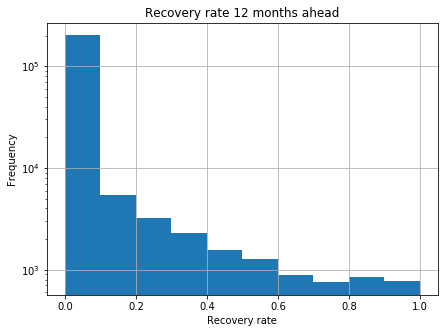

In [86]:
dft['RECOVERY_RATE_12M_AHEAD'].plot.hist(logy=True, figsize=(7,5), grid=True)
plt.title('Recovery rate 12 months ahead')
plt.xlabel('Recovery rate')
plt.show()

In [87]:
f,b=np.histogram(dft['RECOVERY_RATE_12M_AHEAD'], range=[0,1], bins=np.arange(0,1.1,0.1))
f = f/sum(f)
w = 0.7 * (b[1] - b[0])
c = (b[:-1] + b[1:]) / 2

print('Prob. of recovery 12 months ahead: ')
for (b0,b1),f0 in zip(zip(b, b[1:]),f):
    print(' (%.1f, %.1f): %.2f' % (b0,b1,f0))

Prob. of recovery 12 months ahead: 
 (0.0, 0.1): 0.92
 (0.1, 0.2): 0.02
 (0.2, 0.3): 0.01
 (0.3, 0.4): 0.01
 (0.4, 0.5): 0.01
 (0.5, 0.6): 0.01
 (0.6, 0.7): 0.00
 (0.7, 0.8): 0.00
 (0.8, 0.9): 0.00
 (0.9, 1.0): 0.00


In [88]:
dft['HAS_RECOVERED_12M_AHEAD'].value_counts(normalize=True)

False    0.863413
True     0.136587
Name: HAS_RECOVERED_12M_AHEAD, dtype: float64

# Save to file

In [89]:
%%time
dft.to_csv('sample_for_model.csv', index=False)

CPU times: user 20.2 s, sys: 727 ms, total: 20.9 s
Wall time: 22 s
